# IMPORT LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [3]:
import os
import sys
import random
import warnings
import pandas as pd
import math
import cv2
import skimage
from skimage import data
from skimage import io
import datetime
from math import *
from matplotlib import pyplot
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense,ZeroPadding2D,Concatenate,Input,concatenate,MaxPool2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam,Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
import imgaug as ia
from imgaug import augmenters as iaa
import albumentations as A
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from imgaug import augmenters as iaa
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from shutil import copyfile
import shutils
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from ASoftMax import my_forward


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# LOAD DATA

In [19]:
img_rows, img_cols = 28,28
batch_size =16
class_names = ['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX', 'SEVEN', 'EIGHT', 'NINE', 'TEN']
num_classes = len(class_names)


(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# reshape to be [samples][pixels][width][height]
x_train = X_train.reshape(X_train.shape[0], 28, 28,1)
x_test = X_test.reshape(X_test.shape[0],28, 28,1)

# convert from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


train_datagen = ImageDataGenerator(
      rescale=1./512,
      rotation_range=20,
      shear_range=0.2,
      zoom_range=0.2,
      )

#train_datagen.fit(x_train)
validation_datagen = ImageDataGenerator(rescale=1./512)


train_generator = train_datagen.flow(
        x_train, y_train,
        batch_size=batch_size,
        shuffle=True)

validation_generator = validation_datagen.flow(
        x_test, y_test,
        batch_size=batch_size,
        shuffle=True)



# SIDE BRANCH MODULES


In [20]:
l2=tf.keras.regularizers.l2(1e-4)
kernel_init = tf.keras.initializers.he_normal()
bias_init = tf.keras.initializers.Constant(value=0.1)

In [21]:
def inception_module1(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1'):


    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",kernel_regularizer=l2,trainable=True)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='elu', kernel_initializer=kernel_init,trainable=True)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",kernel_regularizer=l2,trainable=True)(conv_5x5)


    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc1')

    return output

In [22]:
def inception_module12(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc12'):


    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",kernel_regularizer=l2,trainable=True)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='elu', kernel_initializer=kernel_init,trainable=True)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",kernel_regularizer=l2,trainable=True)(conv_5x5)


    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc12')

    return output

In [23]:
def inception_module22(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc22'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",kernel_regularizer=l2,trainable=True)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='elu', kernel_initializer=kernel_init,trainable=True)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",kernel_regularizer=l2,trainable=True)(conv_5x5)


    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc22')

    return output

In [24]:
def inception_module1a(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='elu')(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)


    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc2')

    return output

In [25]:
def inception_module1aq(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1q'):


    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='elu')(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(conv_5x5)


    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='elu', kernel_initializer="he_normal",trainable=True)(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc2q')

    return output

# DCNN MAIN MODEL

In [28]:
model = Sequential()
input_layer = Input(shape=(img_rows, img_cols,1))


#############################################
input_half_1 = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(input_layer)

x_0=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_1011')(input_layer)
x=Activation('elu')(x_0)
x=BatchNormalization()(x)
x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_11')(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_1021')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_1031')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)

x0=AveragePooling2D(pool_size=(2, 2))(x)

x1= concatenate([x0, input_half_1])
##############################################
i0=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal")(x1)

i1 = inception_module12(i0,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc12')

i2 = inception_module22(i1,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc22')

i4 = AveragePooling2D(pool_size=(5, 5), padding='same', strides=None, name='max_pool_inception_0_1')(i2)

##############################################
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_2011')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_21')(x1)
x1=ZeroPadding2D((1, 1))(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_2021')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_2031')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)

x2= AveragePooling2D(pool_size=(2, 2))(x1)

y2=AveragePooling2D(pool_size=(2, 2))(x2)

x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_3011')(x2)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_3011')(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_3021')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_3031')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)

x3_1=AveragePooling2D(pool_size=(2, 2)) (x3)

x4_1=concatenate([x3_1,y2])

x4=ZeroPadding2D((1, 1))(x4_1)
x4=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_4011')(x4)
x4=Activation('elu')(x4)
x4=BatchNormalization()(x4)
x6=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_41')(x4)
x6=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal",name='conv2d_4021')(x6)
x6=Activation('elu')(x6)
x6=BatchNormalization()(x6)
x7 =AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None)(x6)


dc_1_0 = Conv2DTranspose(512, (2,2), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal', name='deconv_011')(x7)
dc_1_0=concatenate([i4,dc_1_0])
dc_1 = UpSampling2D((2,2))(dc_1_0)
dc_2_0 = Conv2DTranspose(256, (3, 3),padding = 'same', activation='elu',strides=1,
     dilation_rate=(1,1),kernel_initializer='he_normal',  name='deconv_021')(dc_1)
dc_2 = UpSampling2D((2,2))(dc_2_0)

x7_0 = Flatten()(dc_2)
x7_1 = Dense(512, activation='elu',name='dense11')(x7_0)
x7_2 =BatchNormalization()(x7_1)
x7_2 = Dropout(0.1)(x7_2)
x7_4 = Dense(256, activation='elu',name='dense2_1')(x7_2)
x7_5 =BatchNormalization()(x7_4)
x7_5 = Dropout(0.1)(x7_5)

x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5)
x82 =Activation(my_forward,dynamic=True, name='out2_')(x8_1)


##################
#  Second MODEL
##################

x_0aq=Conv2D(32, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_10_q')(input_layer)
xaq=Activation('elu')(x_0aq)
xaq=BatchNormalization(name='cobatch10q')(xaq)
xaq=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_1aq',trainable=True)(xaq)
xaq=Conv2D(64, (7,7), padding = "same", kernel_initializer="he_normal",name='conv2d_10a2q',trainable=True)(xaq)
xaq=Activation('elu')(xaq)
xaq=BatchNormalization()(xaq)
xaq=Dropout(0.5)(xaq)

x0aq=AveragePooling2D(pool_size=(2, 2))(xaq)

x1aq=x0aq
##############################################
i0aq=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",trainable=True)(x1aq)

i1aq = inception_module1aq(i0aq,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc1q')

i4aq = AveragePooling2D(pool_size=(5,5), padding='same', strides=None, name='max_pool_inception_01aq')(i1aq)
##############################################
x1aq=Conv2D(128, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_201aq',trainable=True)(x1aq)
x1aq=Activation('elu')(x1aq)
x1aq=BatchNormalization()(x1aq)
x1aq=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_2aq',trainable=True)(x1aq)
x1aq=ZeroPadding2D((1, 1))(x1aq)
x1aq=Conv2D(128, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_202aq',trainable=True)(x1aq)
x1aq=Activation('elu')(x1aq)
x1aq=BatchNormalization()(x1aq)
x1aq=Dropout(0.5)   (x1aq)
x2aq= AveragePooling2D(pool_size=(2, 2))(x1aq)
x3aq=Conv2D(256, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_301aq',trainable=True)(x2aq)
x3aq=Activation('elu')(x3aq)
x3aq=BatchNormalization()(x3aq)
x3aq=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_301vq',trainable=True)(x3aq)
x3aq=Conv2D(256, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_302aq')(x3aq)
x3aq=Activation('elu')(x3aq)
x3aq=BatchNormalization()(x3aq)
x3aq=Dropout(0.5)(x3aq)
x3_1aq=AveragePooling2D(pool_size=(2, 2)) (x3aq)
x4aq=ZeroPadding2D((1, 1))(x3_1aq)
x4aq=Conv2D(512, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_401aq')(x4aq)
x4q=Activation('elu')(x4aq)
x4aq=BatchNormalization()(x4aq)
x6aq=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_4aq')(x4aq)
x6aq=Conv2D(512, (7,7), padding = 'same', kernel_initializer="he_normal",name='conv2d_4_q')(x6aq)
x6aq=Activation('elu')(x6aq)
x6aq=BatchNormalization()(x6aq)
x7aq =AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x6aq)

dc_1_0aq = Conv2DTranspose(512, (7,7), activation='elu',strides=1,
      padding = 'same',kernel_initializer='he_normal', name='deconv_01a_q')(x7aq)
dc_1_0aq=concatenate([i4aq,dc_1_0aq])
dc_1aq = UpSampling2D((2,2))(dc_1_0aq)
dc_2_0aq = Conv2DTranspose(256, (7,7),padding = 'same', activation='elu',strides=1,
     dilation_rate=(1,1),kernel_initializer='he_normal',  name='deconv_02aq')(dc_1aq)
dc_2aq = UpSampling2D((2,2))(dc_2_0aq)

x7_0aq = Flatten()(dc_2aq)
x7_1aq = Dense(256, activation='elu',name='dense1aq')(x7_0aq)
x7_2aq =BatchNormalization()(x7_1aq)
x7_2aq = Dropout(0.5)(x7_2aq)
x7_4aq = Dense(128, activation='elu',name='dense2aq')(x7_2aq)
x7_5aq =BatchNormalization()(x7_4aq)
x7_5aq = Dropout(0.5)(x7_5aq)
x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5aq)
x83 =Activation(my_forward,dynamic=True, name='out3_')(x8_1)

#####################

# THIRD MODEL

########################################
x_0=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d__',trainable=True)(input_layer)
x=Activation('elu')(x_0)
x=BatchNormalization()(x)
x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_1',trainable=True)(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_120',trainable=True)(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x0=AveragePooling2D(pool_size=(2, 2))(x)
y1=AveragePooling2D(pool_size=(4, 4))(x)
x1=x0
##############################################
i0=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",trainable=True)(x1)

i1 = inception_module1(i0,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc1')

i4 = AveragePooling2D(pool_size=(3, 3), padding='same', strides=None, name='max_pool_inception_01')(i1)

##############################################
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_201',trainable=True)(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_2',trainable=True)(x1)
x1=ZeroPadding2D((1, 1))(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_202',trainable=True)(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Dropout(0.5)   (x1)
x2= AveragePooling2D(pool_size=(2, 2))(x1)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_301',trainable=True)(x2)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d11',trainable=True)(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_302',trainable=True)(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Dropout(0.5)(x3)
x3_1=AveragePooling2D(pool_size=(2, 2)) (x3)
x4=ZeroPadding2D((1, 1))(x3_1)
x4=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_401',trainable=True)(x4)
x4=Activation('elu')(x4)
x4=BatchNormalization()(x4)
x6=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_4',trainable=True)(x4)
x6=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal",name='conv2d_402',trainable=True)(x6)
x6=Activation('elu')(x6)
x6=BatchNormalization()(x6)
x7 =AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x6)
dc_1_0 = Conv2DTranspose(512, (4, 4), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal', name='deconv_01_',trainable=True)(x7)
dc_1_0=concatenate([i4,dc_1_0])
dc_1 = UpSampling2D((2,2))(dc_1_0)
dc_2_0 = Conv2DTranspose(256, (3, 3),padding = 'same', activation='elu',strides=1,
     dilation_rate=(1,1),kernel_initializer='he_normal',  name='deconv_02',trainable=True)(dc_1)
dc_2 = UpSampling2D((2,2))(dc_2_0)
dc_3_0 = Conv2DTranspose(128, (3, 3), activation='elu',padding = 'valid',strides=1,
     dilation_rate=(1, 1),kernel_initializer='he_normal',  name='deconv_03',trainable=True)(dc_2)
dc_3 = UpSampling2D((2,2))(dc_3_0)

x7_0 = Flatten()(dc_3)
x7_1 = Dense(256, activation='elu',name='dense1',trainable=True)(x7_0)
x7_2 =BatchNormalization()(x7_1)
x7_2 = Dropout(0.5)(x7_2)
x7_4 = Dense(128, activation='elu',name='dense2',trainable=True)(x7_2)
x7_5 =BatchNormalization()(x7_4)
x7_5 = Dropout(0.5)(x7_5)
x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5)
x8 =Activation(my_forward,dynamic=True, name='out1_')(x8_1)

########################
# Fourth Model
########################################
x_0=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d__4',trainable=True)(input_layer)
x=Activation('elu')(x_0)
x=BatchNormalization()(x)
x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_14',trainable=True)(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_124',trainable=True)(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x0=MaxPooling2D(pool_size=(2, 2))(x)

x1=x0

x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_2014',trainable=True)(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_24',trainable=True)(x1)
x1=ZeroPadding2D((1, 1))(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_2024',trainable=True)(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Dropout(0.5)   (x1)

x2= MaxPooling2D(pool_size=(2, 2))(x1)

x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_3014',trainable=True)(x2)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_3014',trainable=True)(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_3024',trainable=True)(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Dropout(0.5)(x3)

x3_1=MaxPooling2D(pool_size=(2, 2)) (x3)

x4=ZeroPadding2D((1, 1))(x3_1)
x4=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_4014',trainable=True)(x4)
x4=Activation('elu')(x4)
x4=BatchNormalization()(x4)

x6=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_44',trainable=True)(x4)

x6=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal",name='conv2d_4024',trainable=True)(x6)
x6=Activation('elu')(x6)
x6=BatchNormalization()(x6)

x7 =AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x6)

dc_1_0 = Conv2DTranspose(512, (4, 4), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal', name='deconv_01_4',trainable=True)(x7)
dc_1 = UpSampling2D((2,2))(dc_1_0)

x7_0 = Flatten()(dc_1)
x7_1 = Dense(128, activation='elu',name='dense14',trainable=True)(x7_0)
x7_2 =BatchNormalization()(x7_1)
x7_2 = Dropout(0.5)(x7_2)
x7_4 = Dense(64, activation='elu',name='dense24',trainable=True)(x7_2)
x7_5 =BatchNormalization()(x7_4)
x7_5 = Dropout(0.5)(x7_5)
x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5)
x81 =Activation(my_forward,dynamic=True, name='out4_')(x8_1)

#### AVERAGE LAYER
x84= tf.keras.layers.Average(name='average')([x8,x82,x83,x81])
###

model = Model(input_layer, [x8,x82,x83,x81,x84], name='Combination_Model')


# Load My Pre-Trained Weights for 100% Accuracy
### Donlowad Pre-trained weights from
[link text]( https://drive.google.com/file/d/1ccsFBBf4DOg9uepQ2yOwE4mLDgA9MuNM/view?usp=sharing)

In [30]:
model.load_weights("/mnist_100%_acc_awar.h5",by_name=True)


# TRAIN

In [ ]:
initial_lrate = 0.0001

def decay(epochs, steps=100):
    drop = 0.95
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+(2*epochs)/epochs_drop)))
    return lrate

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1,
                              patience=3, min_lr=1e-6, verbose=0)

checkpoint = ModelCheckpoint("/WEIHGTS_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.01,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

lr_sc = LearningRateScheduler(decay,verbose=1)

mycallback = [earlystop,checkpoint,reduce_lr]

lossWeights = {'out1_':0.5,'out2_':0.5,'out3_':0.5,'out4_':0.25,'average':1.0}
loss = tf.keras.losses.CategoricalCrossentropy()

#Compile
model.compile(
                loss={'out1_': loss,'out2_':loss,'out3_':loss,'out4_':loss,'average':loss },
                loss_weights=lossWeights,
                optimizer=Adamax(learning_rate=0.001),
               metrics=['accuracy'])

# define additional training parameters
nb_train_samples = 60000
nb_validation_samples = 10000
epochs = 30

#Fit
history = model.fit_generator (train_datagen.flow(x_train, y_train, batch_size=batch_size)
                    , steps_per_epoch=nb_train_samples//batch_size
                    ,validation_data=validation_generator
                    ,validation_steps=nb_validation_samples//batch_size
                    , epochs=epochs
                    , callbacks = mycallback
                    , verbose = 1
                    ,workers= 8
                    )

Saving TensorBoard log files to: tensorflow_hub/ENSEMBLE MODEL MNIST_Ex2/20230622-233845
Epoch 1/20


<ipython-input-58-12c4754e5290>:71: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator (train_datagen.flow(x_train, y_train, batch_size=batch_size)


625/625 [==============================] - ETA: 0s - loss: 0.6958 - out1__loss: 0.2734 - out2__loss: 0.1865 - out3__loss: 0.2708 - out4__loss: 0.2030 - average_loss: 0.1387 - out1__accuracy: 0.9233 - out2__accuracy: 0.9474 - out3__accuracy: 0.9188 - out4__accuracy: 0.9426 - average_accuracy: 0.9772
Epoch 1: val_loss improved from inf to 0.25955, saving model to /content/drive/MyDrive/optimizer/ensemble_3&5_1_1_1_2_2_2_0.h5
625/625 [==============================] - 590s 876ms/step - loss: 0.6958 - out1__loss: 0.2734 - out2__loss: 0.1865 - out3__loss: 0.2708 - out4__loss: 0.2030 - average_loss: 0.1387 - out1__accuracy: 0.9233 - out2__accuracy: 0.9474 - out3__accuracy: 0.9188 - out4__accuracy: 0.9426 - average_accuracy: 0.9772 - val_loss: 0.2596 - val_out1__loss: 0.0233 - val_out2__loss: 0.0927 - val_out3__loss: 0.0343 - val_out4__loss: 0.1300 - val_average_loss: 0.0339 - val_out1__accuracy: 0.9940 - val_out2__accuracy: 0.9784 - val_out3__accuracy: 0.9928 - val_out4__accuracy: 0.9543 - v


# Ploting  Loss and Accuracy_ View 1

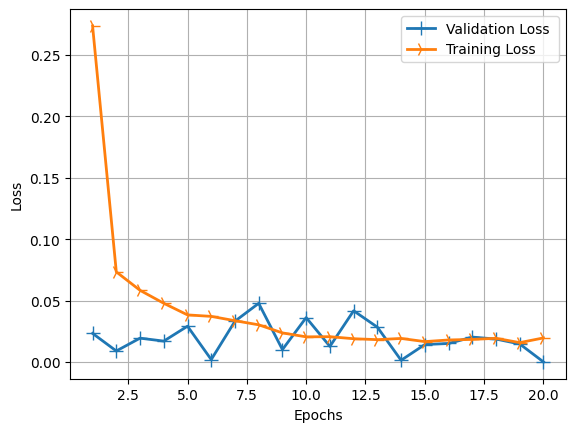

In [ ]:
# Plotting Loss
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['out1__loss']
val_loss_values = history_dict['val_out1__loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss ')
line2 = plt.plot(epochs, loss_values, label='Training Loss ')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

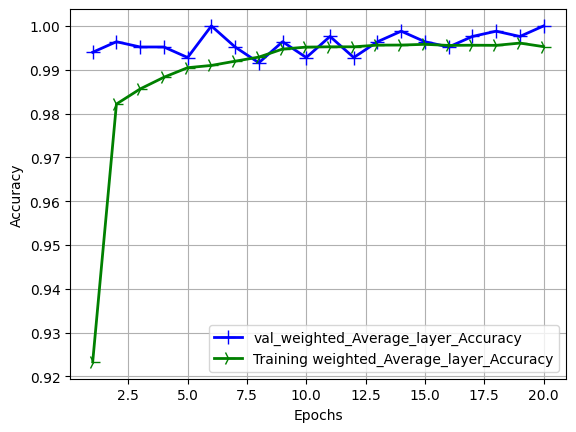

[0.9939903616905212, 0.9963942170143127, 0.995192289352417, 0.995192289352417, 0.9927884340286255, 1.0, 0.995192289352417, 0.9915865659713745, 0.9963942170143127, 0.9927884340286255, 0.9975961446762085, 0.9927884340286255, 0.9963942170143127, 0.9987980723381042, 0.9963942170143127, 0.995192289352417, 0.9975961446762085, 0.9987980723381042, 0.9975961446762085, 1.0]


In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['out1__accuracy']
val_acc_values = history_dict['val_out1__accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, color='b',label='val_weighted_Average_layer_Accuracy')
line2 = plt.plot(epochs, acc_values,color='g', label='Training weighted_Average_layer_Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
print (val_acc_values)

# Ploting  Loss and Accuracy_ View 2

In [ ]:
acc = history.history['average_accuracy']
val_acc = history.history['val_average_accuracy']
loss = history.history['average_loss']
val_loss = history.history['val_average_loss']

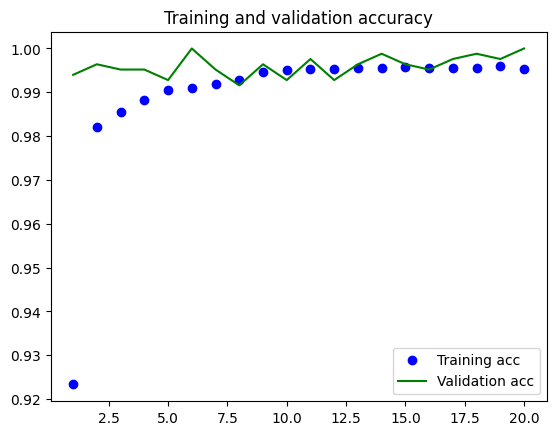

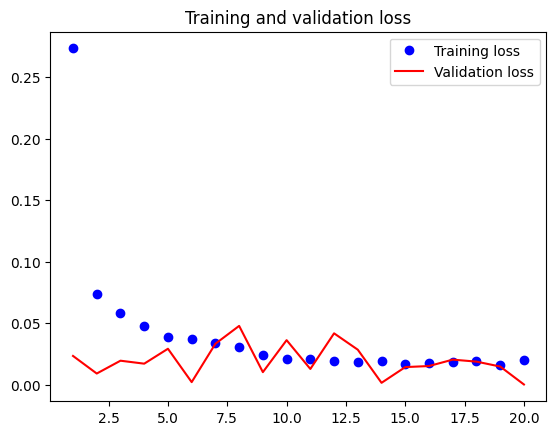

In [ ]:
acc = history.history['out1__accuracy']
val_acc = history.history['val_out1__accuracy']
loss = history.history['out1__loss']
val_loss = history.history['val_out1__loss']
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()